In [1]:
import tqdm
import mlmi
import mlmi3
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.cluster
import sklearn.covariance
import networkx as nx
import densratio
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)

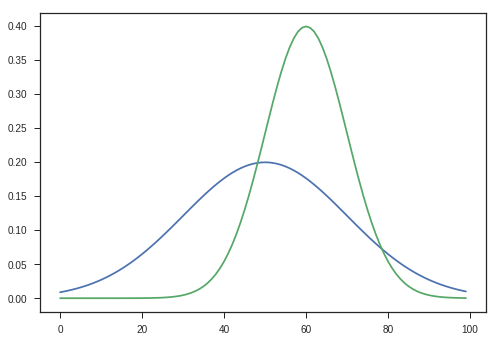

In [2]:
plt.plot([scipy.stats.norm(0, 2).pdf(x) for x in np.arange(-5, 5, 0.1)])
plt.plot([scipy.stats.norm(1, 1).pdf(x) for x in np.arange(-5, 5, 0.1)])

In [3]:
X_tr = scipy.stats.norm(0, 2).rvs(300)
X_te = scipy.stats.norm(1, 1).rvs(1000)

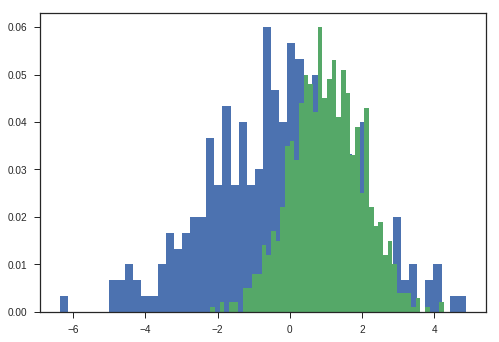

In [4]:
weights_tr = np.ones_like(X_tr)/len(X_tr)
weights_te = np.ones_like(X_te)/len(X_te)
plt.hist(X_tr, bins=50, weights=weights_tr)
plt.hist(X_te, bins=50, weights=weights_te)
plt.show()

In [5]:
class ULsifLooCV(object):
    def __init__(self, sigmas, lambdas):
        self._sigmas = sigmas
        self._lambdas = lambdas
    
    def fit(self, X_tr, X_te):
        n_tr = len(X_tr)
        n_te = len(X_te)
        b = min(100, n_te)
        n = min(n_tr, n_te)
        means = sklearn.cluster.KMeans(b).fit(X_tr).cluster_centers_
        
        def norm(mean, sigma):
            cov = np.eye(len(mean)) * sigma
            return lambda x: scipy.stats.multivariate_normal.pdf(x, mean=mean, cov=cov)
        
        score = np.inf
        for sigma in self._sigmas:
            bases = [norm(mean, sigma) for mean in means]
            phi = np.array([b(X_tr) for b in bases])
            H = np.einsum('ik,jk->ij', phi, phi) / n_tr
            h = np.mean([b(X_te) for b in bases], axis=1)
            phi_tr = np.array([b(X_tr[:n]) for b in bases])
            phi_te = np.array([b(X_te[:n]) for b in bases])
            
            for lamb in self._lambdas:
                B = H + lamb * (n_tr - 1) / n_tr * np.eye(b)
                B_inv_phi_tr = np.linalg.solve(B, phi_tr)
                denom = n_tr - np.sum(phi_tr * B_inv_phi_tr, axis=0)
                B0 = np.repeat(np.linalg.solve(B, h), n).reshape(b, n)
                B0 += B_inv_phi_tr * (h.dot(B_inv_phi_tr) / denom).reshape(1, -1)
                B1 = np.linalg.solve(B, phi_te)
                B1 += B_inv_phi_tr * (np.sum(phi_te * B_inv_phi_tr, axis=0) / denom).reshape(1, -1)
                B2 = (n_tr - 1) / n_tr / (n_te - 1) * (n_te * B0 - B1)
                B2[B2 < 0] = 0
                w_tr = np.sum(phi_tr * B2, axis=0)
                score_new = w_tr.dot(w_tr) / n / 2 - np.sum(phi_te * B2) / n
                if score > score_new:
                    score = score_new
                    self.sigma_opt = sigma
                    self.lambda_opt = lamb
                    print('sigma: %f, lambda: %f, score: %f' % (sigma, lamb, score))
        
        return self

In [6]:
sigmas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1, 1.25, 1.5, 2, 2.5, 3, 5, 10]
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75]
cv = ULsifLooCV(sigmas=sigmas, lambdas=lambdas)
cv.fit(X_tr.reshape(-1, 1), X_te.reshape(-1, 1))

sigma: 0.010000, lambda: 0.000001, score: 100659.646273
sigma: 0.010000, lambda: 0.000010, score: 11251.404714
sigma: 0.010000, lambda: 0.000100, score: 522.927709
sigma: 0.010000, lambda: 0.001000, score: 26.208932
sigma: 0.010000, lambda: 0.010000, score: 0.724901
sigma: 0.010000, lambda: 0.050000, score: -0.499364
sigma: 0.010000, lambda: 0.100000, score: -0.620837
sigma: 0.010000, lambda: 0.200000, score: -0.700751
sigma: 0.010000, lambda: 0.300000, score: -0.731383
sigma: 0.010000, lambda: 0.500000, score: -0.749414
sigma: 0.050000, lambda: 0.050000, score: -0.766210
sigma: 0.050000, lambda: 0.100000, score: -0.791784
sigma: 0.050000, lambda: 0.200000, score: -0.808574
sigma: 0.050000, lambda: 0.300000, score: -0.810948
sigma: 0.100000, lambda: 0.100000, score: -0.812807
sigma: 0.100000, lambda: 0.200000, score: -0.822269
sigma: 0.100000, lambda: 0.300000, score: -0.823113
sigma: 0.200000, lambda: 0.100000, score: -0.831007
sigma: 0.200000, lambda: 0.200000, score: -0.838620
sigma

In [7]:
cv.sigma_opt, cv.lambda_opt

(1, 0.1)

In [8]:
b = 100
sigma = cv.sigma_opt
lamb = cv.lambda_opt
means = sklearn.cluster.KMeans(b).fit(X_tr.reshape(-1, 1)).cluster_centers_[:, 0]

def norm(mean, sigma):
    return lambda x: scipy.stats.norm.pdf(x, loc=mean, scale=sigma)

bases = [norm(mean, sigma) for mean in means]

In [9]:
phi = np.array([b(X_tr) for b in bases])
H = np.einsum('ik,jk->ij', phi, phi) / len(X_tr)
h = np.mean([b(X_te) for b in bases], axis=1)

In [10]:
alpha = np.linalg.solve(H + lamb * np.eye(b), h)
alpha[alpha < 0] = 0

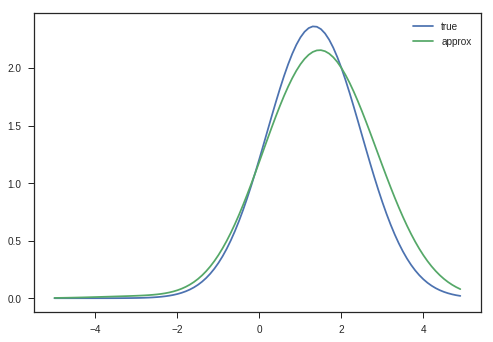

In [11]:
def true_ratio(x):
    return scipy.stats.norm(1, 1).pdf(x) / scipy.stats.norm(0, 2).pdf(x)

def approximated_ratio(x):
    return np.sum([alpha[i] * bases[i](x) for i in range(b)])

plt.plot(np.arange(-5, 5, 0.1), [true_ratio(x) for x in np.arange(-5, 5, 0.1)], label='true')
plt.plot(np.arange(-5, 5, 0.1), [approximated_ratio(x) for x in np.arange(-5, 5, 0.1)], label='approx')
plt.legend()